<a href="https://colab.research.google.com/github/yeonmi02/dlproject/blob/main/dlproject_data_MLP_TabNet_Entity_Embedding_%2B_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 불러오기

In [145]:
# 관련 라이브러리 임포트
import torch
import numpy as np
import random

# 모델 학습 결과를 고정시키기 위한 시드 고정하는 코드
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [146]:
# 관련 라이브러리 임포트하는 코드
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오는 코드
patient = pd.read_csv('/content/drive/MyDrive/hospital data analysis.csv')
patient.head(10)

,Patient_ID,Age,Gender,Condition,Procedure,Cost,Length_of_Stay,Readmission,Outcome,Satisfaction
0,1,45,Female,Heart Disease,Angioplasty,15000,5,No,Recovered,4
1,2,60,Male,Diabetes,Insulin Therapy,2000,3,Yes,Stable,3
2,3,32,Female,Fractured Arm,X-Ray and Splint,500,1,No,Recovered,5
3,4,75,Male,Stroke,CT Scan and Medication,10000,7,Yes,Stable,2
4,5,50,Female,Cancer,Surgery and Chemotherapy,25000,10,No,Recovered,4
5,6,68,Male,Hypertension,Medication and Counseling,1000,2,No,Stable,4
6,7,55,Female,Appendicitis,Appendectomy,8000,4,No,Recovered,3
7,8,40,Male,Fractured Leg,Cast and Physical Therapy,3000,6,No,Recovered,4
8,9,70,Female,Heart Attack,Cardiac Catheterization,18000,8,Yes,Stable,2
9,10,25,Male,Allergic Reaction,Epinephrine Injection,100,1,No,Recovered,5


# 데이터 전처리 하기

In [147]:
# 전처리를 하기 위한 라이브러리 임포트하는 코드
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [148]:
# 데이터 안에 존재하는 특성 출력하는 코드
print(patient.columns.tolist())

['Patient_ID', 'Age', 'Gender', 'Condition', 'Procedure', 'Cost', 'Length_of_Stay', 'Readmission', 'Outcome', 'Satisfaction']


In [149]:
# 예측하는 과정에서 필요없는 특성을 제거하는 코드
if 'Patient_ID' in patient.columns:
    patient.drop(columns=['Patient_ID'], inplace=True)

In [150]:
# 데이터에서 결측값들을 적절하게 채우는 코드
patient.fillna({
    'Age': patient['Age'].median(),
    'Gender': patient['Gender'].mode()[0],
    'Condition': 'Unknown',
    'Procedure': 'Unknown',
    'Cost': patient['Cost'].median(),
    'Length_of_Stay': patient['Length_of_Stay'].median(),
    'Readmission': 'No',
    'Outcome': 'Unknown',
    'Satisfaction': patient['Satisfaction'].mode()[0]
}, inplace=True)

In [151]:
# 범주형 특성들을 수치형으로 변환하는 코드
le = LabelEncoder()
patient['Outcome_Label'] = le.fit_transform(patient['Outcome'])

In [152]:
# 환자의 데이터를 원핫인코딩하는 코드
categorical_cols = ['Gender', 'Condition', 'Procedure', 'Readmission']
patient = pd.get_dummies(patient, columns=categorical_cols)

In [153]:
# 데이터 프레임에서 특정 이름으로 시작하는 칼럼 삭제하는 코드
patient.drop(columns=[col for col in patient.columns if col.startswith('Outcome_')], inplace=True)

In [154]:
# 입력변수와 타겟변수를 처리하는 코드
X = patient.drop(columns=['Outcome'])
y = patient['Outcome']

In [155]:
# 입력 데이터를 바탕으로 표준화를 진행하는 코드
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [156]:
# 데이터를 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [157]:
# 데이터 전처리를 완료하고 확인하는 코드
print("데이터 전처리 완료함")
print("X_train shape:", X_train.shape)
print("y label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

데이터 전처리 완료함
X_train shape: (787, 38)
y label mapping: {'Recovered': np.int64(0), 'Stable': np.int64(1)}


In [158]:
# 입력 데이터의 크기와 타겟 데이터의 크기를 확인하는 코드
X_scaled.shape
y.shape

(984,)

In [159]:
from sklearn.preprocessing import LabelEncoder

# 범주형 타켓 변수를 숫자 레이블로 변환하는 코드
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [160]:
# 각 변수의 타입을 확인하는 코드
print(type(y_train))
print(y_train[:10])
print([type(x) for x in y_train[:10]])

<class 'pandas.core.series.Series'>
507       Stable
345       Stable
933       Stable
71     Recovered
544    Recovered
645       Stable
532       Stable
905       Stable
658    Recovered
562       Stable
Name: Outcome, dtype: object
[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


In [161]:
# 라벨 값의 종류를 확인하는 코드
print("라벨 종류:", patient['Outcome'].unique())

# 라벨의 분포 형태 알아보는 코드
print("라벨 분포:")
print(patient['Outcome'].value_counts())

# 결측치를 확인하는 코드
missing_labels = patient['Outcome'].isnull().sum()
print(f"라벨 결측치 개수: {missing_labels}")

라벨 종류: ['Recovered' 'Stable']
라벨 분포:
Outcome
Recovered    591
Stable       393
Name: count, dtype: int64
라벨 결측치 개수: 0


In [162]:
import pandas as pd

# 훈련 데이터와 테스트 데이터의 라벨 분포를 출력하는 코드
print("Train 라벨 분포:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest 라벨 분포:")
print(pd.Series(y_test).value_counts(normalize=True))

Train 라벨 분포:
Outcome
Recovered    0.601017
Stable       0.398983
Name: proportion, dtype: float64

Test 라벨 분포:
Outcome
Recovered    0.598985
Stable       0.401015
Name: proportion, dtype: float64


In [163]:
import numpy as np

# 넘파이 배열로 변환하는 코드
if 'pandas' in str(type(X_train)):
    X_train = X_train.to_numpy(dtype=np.float32)
    X_test = X_test.to_numpy(dtype=np.float32)

if 'pandas' in str(type(y_train)):

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # 넘파이 배열로 변환하는 코드
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

# 다층 퍼셉트론 모델 구현하기

In [164]:
# 관련 라이브러리 임포트하는 코드
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [165]:
# 모델 구현하고 컴파일하는 코드
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
# 딥러닝 모델을 훈련시키는 코드
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=2
)

Epoch 1/25
25/25 - 2s - 67ms/step - accuracy: 0.7827 - loss: 0.5309 - val_accuracy: 1.0000 - val_loss: 0.3276
Epoch 2/25
25/25 - 0s - 17ms/step - accuracy: 1.0000 - loss: 0.2216 - val_accuracy: 1.0000 - val_loss: 0.1196
Epoch 3/25
25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0746 - val_accuracy: 1.0000 - val_loss: 0.0372
Epoch 4/25
25/25 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 1.0000 - val_loss: 0.0146
Epoch 5/25
25/25 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 0.0079
Epoch 6/25
25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 7/25
25/25 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 8/25
25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 9/25
25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 10/25
25/

In [167]:
# 훈련한 데이터로 예측하고 평가하는 코드
y_train_pred = (model.predict(X_train) >= 0.5).astype(int).reshape(-1)
y_test_pred = (model.predict(X_test) >= 0.5).astype(int).reshape(-1)

print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


In [168]:
from sklearn.metrics import classification_report, confusion_matrix

# 훈련 데이터셋을 예측하는 코드
y_train_pred_prob = model.predict(X_train)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()

# 테스트 데이터셋을 예측하는 코드
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [169]:
# 훈련 데이터셋을 평가하는 코드
print("Train 데이터 성능:")
print(classification_report(y_train, y_train_pred))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train, y_train_pred))

# 테스트 데이터셋을 평가하는 코드
print("\nTest 데이터 성능:")
print(classification_report(y_test, y_test_pred))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_test_pred))

Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       314

    accuracy                           1.00       787
   macro avg       1.00      1.00      1.00       787
weighted avg       1.00      1.00      1.00       787

Train 데이터 혼동 행렬:
[[473   0]
 [  0 314]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


##  * 문제점

- 과적합 된 가능성이 있어서 데이터 양을 늘리는 방향으로 해결해볼 수 있다







In [170]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 데이터 불균형을 조정하기위해 SMOTE 사용하는 코드
print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

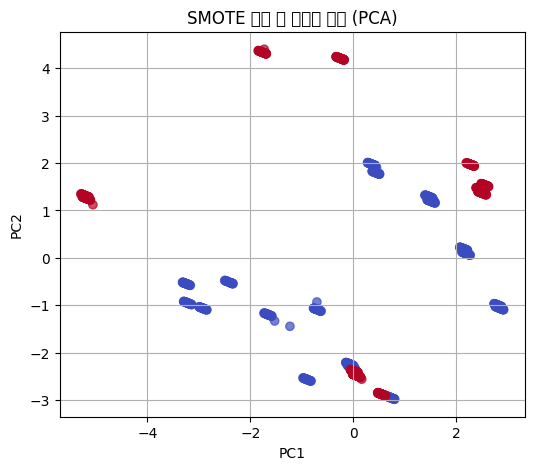

In [171]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 주성분 분석하는 코드
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# 시각화하는 코드
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_resampled, cmap='coolwarm', alpha=0.7)
plt.title('SMOTE 적용 후 데이터 분포 (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [172]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 훈련 데이터에 SMOTE를 적용해서 균형을 맞추는 코드
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({np.float32(0.0): 473, np.float32(1.0): 314})
After SMOTE: Counter({np.float32(1.0): 473, np.float32(0.0): 473})


In [173]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [174]:
# 모델 다시 생성하고 컴파일하는 코드
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [175]:
# 모델 재훈련하는 코드
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7297 - loss: 0.5423 - val_accuracy: 1.0000 - val_loss: 0.2307
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1610 - val_accuracy: 1.0000 - val_loss: 0.0779
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0521 - val_accuracy: 1.0000 - val_loss: 0.0269
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0114
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss

In [176]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측하는 코드
y_pred_train = model.predict(X_train_resampled).round()
y_pred_test = model.predict(X_test).round()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [177]:
# 평가 지표들을 출력하는 코드
print("Train 데이터 성능:")
print(classification_report(y_train_resampled, y_pred_train))
print("Train 데이터 혼동 행렬:")
print(confusion_matrix(y_train_resampled, y_pred_train))

print("\nTest 데이터 성능:")
print(classification_report(y_test, y_pred_test))
print("Test 데이터 혼동 행렬:")
print(confusion_matrix(y_test, y_pred_test))

Train 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       473
         1.0       1.00      1.00      1.00       473

    accuracy                           1.00       946
   macro avg       1.00      1.00      1.00       946
weighted avg       1.00      1.00      1.00       946

Train 데이터 혼동 행렬:
[[473   0]
 [  0 473]]

Test 데이터 성능:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       118
         1.0       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Test 데이터 혼동 행렬:
[[118   0]
 [  0  79]]


## 교차검증 해보기

In [178]:
# 교차검증을 위한 라이브러리 임포트하는 코드
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

In [179]:
# MLP 모델 코드
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [180]:
# 장치를 설정하고 검증 코드 준비하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [181]:
from sklearn.preprocessing import LabelEncoder

# y 전체에 라벨 인코더를 적용하는 코드
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y))

# 5층 교차검증을 순차적으로 완료하는 코드
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded.iloc[train_idx], y_encoded.iloc[val_idx]

    X_train = pd.get_dummies(X_train).astype(float)
    X_val = pd.get_dummies(X_val).astype(float)
    X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32),
                                  torch.tensor(y_train.values, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32),
                                torch.tensor(y_val.values, dtype=torch.long))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = MLP(input_dim=X.shape[1], output_dim=len(set(y))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

In [182]:
    model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
# 모델 학습하는 코드

In [183]:
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true.extend(labels.numpy())

    acc = accuracy_score(true, preds)
    print(f"Fold {fold} Accuracy: {acc}")

# 평가하는 코드

Fold 4 Accuracy: 0.7244897959183674


# MLP 모델 구현 후기

### 1. 우선 데이터 셋의 양이 적어서 그런건지 아닌지 모르겠지만 과적합이 의심되는 결과가 나타나고 있고 데이터 셋도 늘려봤지만 성능이 100%로 그대로여서 소용이 없었습니다.

### 2. 정말 데이터가 잘 학습되고 모델이 잘 형성되어서 성능이 완벽한 MLP가 만들어진 것인지 모르겠어서 다른 모델로도 학습을 해보려고 합니다.

# TabNet 모델 구현하기

In [184]:
# TabNet 라이브러리 설치
!pip install pytorch-tabnet

In [185]:
# 관련 라이브러리 임포트하는 코드
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report
import torch
from sklearn.preprocessing import LabelEncoder

In [186]:
# 문자형 타겟 변수를 수치형으로 변환하는 코드
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [187]:
# 데이터를 넘파이 배열로 변환하는 코드
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

In [188]:
# 장치 설정하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [189]:
# TabNet 모델을 구현하는 코드
clf = TabNetClassifier(
    device_name=device.type,
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [190]:
# 모델 학습하는 코드
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.83758 | test_accuracy: 0.62944 |  0:00:00s
epoch 1  | loss: 0.37828 | test_accuracy: 0.74112 |  0:00:00s
epoch 2  | loss: 0.37995 | test_accuracy: 0.74619 |  0:00:01s
epoch 3  | loss: 0.1309  | test_accuracy: 0.8731  |  0:00:01s
epoch 4  | loss: 0.04893 | test_accuracy: 0.8731  |  0:00:01s
epoch 5  | loss: 0.03625 | test_accuracy: 0.90355 |  0:00:02s
epoch 6  | loss: 0.01171 | test_accuracy: 0.90355 |  0:00:02s
epoch 7  | loss: 0.02636 | test_accuracy: 0.90355 |  0:00:03s
epoch 8  | loss: 0.01302 | test_accuracy: 0.93401 |  0:00:03s
epoch 9  | loss: 0.01685 | test_accuracy: 0.93401 |  0:00:04s
epoch 10 | loss: 0.00631 | test_accuracy: 0.93401 |  0:00:04s
epoch 11 | loss: 0.02351 | test_accuracy: 0.93401 |  0:00:05s
epoch 12 | loss: 0.02349 | test_accuracy: 0.93401 |  0:00:06s
epoch 13 | loss: 0.00767 | test_accuracy: 1.0     |  0:00:06s
epoch 14 | loss: 0.00405 | test_accuracy: 1.0     |  0:00:07s
epoch 15 | loss: 0.00217 | test_accuracy: 0.93401 |  0:00:07s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [191]:
# 평가하고 결과 출력하는 코드
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [192]:
# 예측된 확률을 알아보는 코드
proba = clf.predict_proba(X_test)

recovered_idx = 0
recovered_proba = proba[:, recovered_idx]

# 치료 가능성에 대한 예측을 출력하는 코드
recovered_proba = proba[:, recovered_idx]

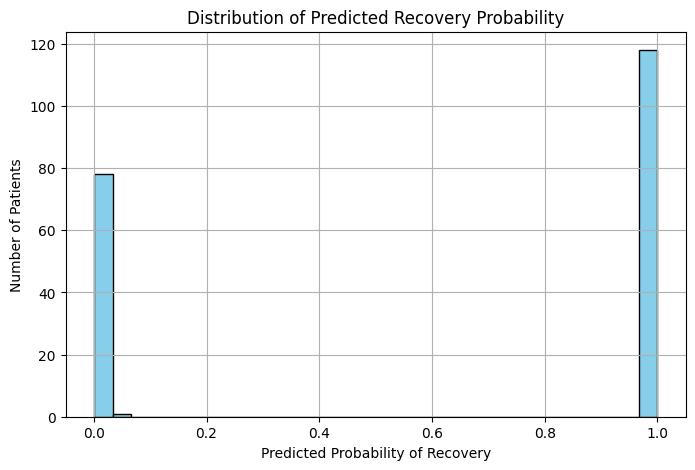

In [193]:
import matplotlib.pyplot as plt

# 시각화하는 코드
plt.figure(figsize=(8, 5))
plt.hist(recovered_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Recovery Probability")
plt.xlabel("Predicted Probability of Recovery")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()

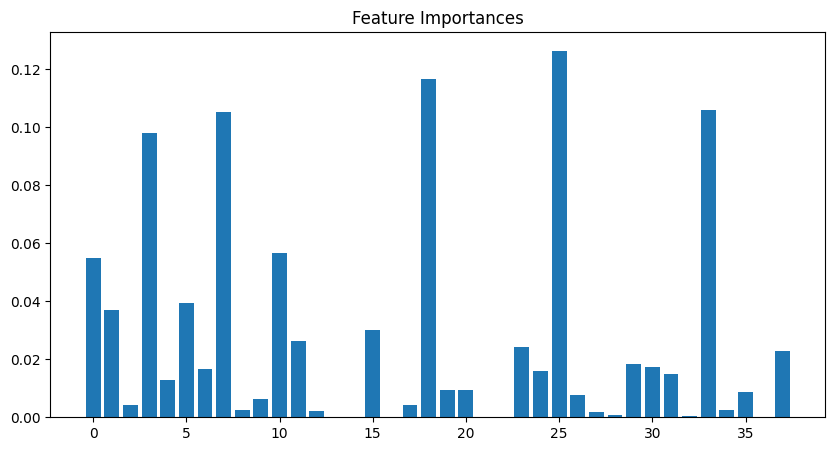

In [194]:
# 중요한 특성을 시각화하는 코드
plt.figure(figsize=(10, 5))
plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.title("Feature Importances")
plt.show()

## * 문제점 : MLP와 역시 과적합 문제 발생

1. SMOTE을 사용하는 방식의 오류일 수 있으므로 올바르게 조정한다
2. 하이퍼파라미터 조정 방식으로 문제 해결

In [195]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터를 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 데이터 불균형을 처리하는 코드
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [196]:
from pytorch_tabnet.tab_model import TabNetClassifier

# TabNet 모델 구현하는 코드
clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=1e-4,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',    #
    verbose=1,
    seed=42
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


## * 모델 학습 오류로 변환 다시 실행

In [197]:
# 데이터 타입과 결측값을 확인하는 코드
print(X_train_res.dtypes)
print(X_train_res.isnull().sum())

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [198]:
from sklearn.preprocessing import LabelEncoder

# 문자형 범수를 처리하는 코드
for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))

# 결측값을 처리하는 코드
X_train_res = X_train_res.fillna(0)

In [199]:
# 테스트 데이터 셋에도 같은 처리하는 코드
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))
X_test = X_test.fillna(0)

In [200]:
# 다시 데이터 타입과 결측값 확인하는 코드
print(X_train_res.dtypes)
print(X_train_res.isnull().sum())
print(X_train_res.head())

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [201]:
from sklearn.preprocessing import LabelEncoder

encoders = {}

# 데이터 별로 인코딩하는 코드
for col in X_train_res.columns:
    if X_train_res[col].dtype == 'object':
        le = LabelEncoder()
        X_train_res[col] = le.fit_transform(X_train_res[col].astype(str))
        if col in X_test.columns:
            X_test[col] = le.transform(X_test[col].astype(str))
        encoders[col] = le

In [202]:
# NAN값을 0으로 채우는 전처리 코드
X_train_res = X_train_res.fillna(0)
X_test = X_test.fillna(0)

In [203]:
# 데이터 타입 확인하는 코드
print(X_train_res.dtypes)
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [204]:
# bool 타입 데이터를 int 형태로 변환하는 코드
bool_cols = X_train_res.select_dtypes(include=['bool']).columns
X_train_res[bool_cols] = X_train_res[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [205]:
 # bool이 int로 바뀌었는지 확인하는 코드
print(X_train_res.dtypes)
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                     int64
Gender_Male                                       int64
Condition_Allergic Reaction                       int64
Condition_Appendicitis                            int64
Condition_Cancer                                  int64
Condition_Childbirth                              int64
Condition_Diabetes                                int64
Condition_Fractured Arm                           int64
Condition_Fractured Leg                           int64
Condition_Heart Attack                            int64
Condition_Heart Disease                           int64
Condition_Hypertension                            int64
Condition_Kidney Stones                           int64
Condition_Osteoarthritis                        

In [206]:
# 모델을 학습하는 코드
clf.fit(
    X_train_res.values, y_train_res.values,
    eval_set=[(X_train_res.values, y_train_res.values), (X_test.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.76786 | train_accuracy: 0.37738 | valid_accuracy: 0.28934 |  0:00:00s
epoch 1  | loss: 0.41146 | train_accuracy: 0.30973 | valid_accuracy: 0.30964 |  0:00:00s
epoch 2  | loss: 0.18341 | train_accuracy: 0.43235 | valid_accuracy: 0.41624 |  0:00:00s
epoch 3  | loss: 0.06209 | train_accuracy: 0.67653 | valid_accuracy: 0.62944 |  0:00:01s
epoch 4  | loss: 0.02219 | train_accuracy: 0.72199 | valid_accuracy: 0.63452 |  0:00:01s
epoch 5  | loss: 0.00407 | train_accuracy: 0.72516 | valid_accuracy: 0.69036 |  0:00:01s
epoch 6  | loss: 0.00154 | train_accuracy: 0.73044 | valid_accuracy: 0.70051 |  0:00:01s
epoch 7  | loss: 0.00094 | train_accuracy: 0.68076 | valid_accuracy: 0.69543 |  0:00:02s
epoch 8  | loss: 0.00086 | train_accuracy: 0.64059 | valid_accuracy: 0.6599  |  0:00:02s
epoch 9  | loss: 0.00044 | train_accuracy: 0.62474 | valid_accuracy: 0.71574 |  0:00:03s
epoch 10 | loss: 0.00027 | train_accuracy: 0.64271 | valid_accuracy: 0.73096 |  0:00:03s
epoch 11 | loss: 0.00

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [207]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 예측하는 코드
y_pred = clf.predict(X_test.values)

# 평가 관련 지표 출력하는 코드
print("Classification Report:")
print(classification_report(y_test.values, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test.values, y_pred))

print("Accuracy:", accuracy_score(y_test.values, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Recovered       1.00      1.00      1.00       118
      Stable       1.00      1.00      1.00        79

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

Confusion Matrix:
[[118   0]
 [  0  79]]
Accuracy: 1.0


## 아직도 과적합 의심이라 검증셋과 다른 지표도 확인

In [208]:
from sklearn.model_selection import train_test_split

# 데이터 분할하는 코드
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# 훈련 데이터를 검증 데이터 셋으로 분할하는 코드
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, stratify=y_train_full, test_size=0.2, random_state=42)

In [209]:
# bool 타입 데이터를 int 형태로 변환하는 코드
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include='bool').columns})
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [210]:
# 데이터 타입 별 개수를 출력하는 코드
print(X_train.dtypes.value_counts())

int64    38
Name: count, dtype: int64


In [211]:
# 각 데이터를 넘파이 배열로 변환하는 코드
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

In [212]:
# 정수형으로 변환하는 코드
X_val = X_val.astype({col: 'int' for col in X_val.select_dtypes(include='bool').columns})

In [213]:
# 넘파이 배열로 바꾸고 정수형으로 변환하는 코드
X_val_np = X_val.values.astype(np.float32)
y_val_pred = clf.predict(X_val_np)

In [214]:
# 학습하는 코드
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20
)

epoch 0  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 1  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 2  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 3  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 4  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 5  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 6  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 7  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 8  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 9  | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 10 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 11 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 12 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 13 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


epoch 14 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 15 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 16 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 17 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 18 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 19 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s
epoch 20 | loss: 0.0     | val_accuracy: 0.44304 |  0:00:00s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_accuracy = 0.44304


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [215]:
# 예측하는 코드
y_val_pred = clf.predict(X_val_np)

# 평가 출력하는 코드
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

              precision    recall  f1-score   support

   Recovered       0.59      0.23      0.33        95
      Stable       0.40      0.76      0.52        63

    accuracy                           0.44       158
   macro avg       0.50      0.50      0.43       158
weighted avg       0.52      0.44      0.41       158



## 문제점 :
- loss가 계속 0이고 val_accuracy가 전혀 개선되지 않음
- Early stopping도 20 에폭까지 돌았지만 성능 개선이 전혀 없음


## 해결 방법:
- int 변환하고 전처리들을 다시 한 다음에 모델 구조를 변화하는 방식으로 진행한다
- 훈련/검증 데이터 분리하고 적절한 하이퍼파라미터 조정한 다음 데이터 타입의 문제도 해결했다
            


In [216]:
from sklearn.preprocessing import StandardScaler

# bool 타입을 int로 변환하는 코드
for df in [X_train, X_val]:
    df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)

# 스케일링하는 코드
scaler = StandardScaler()
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

# 넘파이로 변환하는 코드
X_train_np = X_train.values.astype(np.float32)
X_val_np = X_val.values.astype(np.float32)
y_train_np = y_train.values
y_val_np = y_val.values

In [217]:
from pytorch_tabnet.tab_model import TabNetClassifier

# 모델 구현하는 코드
clf = TabNetClassifier(
    n_d=8, n_a=8,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=0.02),
    mask_type='entmax'
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [218]:
# 모델 학습하는 코드
clf.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.89465 | val_accuracy: 0.56329 |  0:00:00s
epoch 1  | loss: 0.43948 | val_accuracy: 0.61392 |  0:00:00s
epoch 2  | loss: 0.24774 | val_accuracy: 0.67089 |  0:00:00s
epoch 3  | loss: 0.11043 | val_accuracy: 0.6962  |  0:00:00s
epoch 4  | loss: 0.06475 | val_accuracy: 0.84177 |  0:00:00s
epoch 5  | loss: 0.04392 | val_accuracy: 0.89873 |  0:00:00s
epoch 6  | loss: 0.01666 | val_accuracy: 0.89873 |  0:00:00s
epoch 7  | loss: 0.00592 | val_accuracy: 0.89873 |  0:00:00s
epoch 8  | loss: 0.01889 | val_accuracy: 0.91772 |  0:00:00s
epoch 9  | loss: 0.00661 | val_accuracy: 0.82278 |  0:00:01s
epoch 10 | loss: 0.00757 | val_accuracy: 0.81646 |  0:00:01s
epoch 11 | loss: 0.0061  | val_accuracy: 0.84177 |  0:00:01s
epoch 12 | loss: 0.00236 | val_accuracy: 0.87342 |  0:00:01s
epoch 13 | loss: 0.03436 | val_accuracy: 0.87342 |  0:00:01s
epoch 14 | loss: 0.00868 | val_accuracy: 0.89873 |  0:00:01s
epoch 15 | loss: 0.00149 | val_accuracy: 0.89873 |  0:00:01s
epoch 16 | loss: 0.00173

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [219]:
# 예측하는 코드
y_val_pred = clf.predict(X_val_np)
from sklearn.metrics import classification_report
print(classification_report(y_val_np, y_val_pred))

              precision    recall  f1-score   support

   Recovered       0.88      1.00      0.94        95
      Stable       1.00      0.79      0.88        63

    accuracy                           0.92       158
   macro avg       0.94      0.90      0.91       158
weighted avg       0.93      0.92      0.92       158



## 위의 결과를 보면 학습이 안정적으로 잘 되고 있고 precision, recall, f1-score 모두 꽤 괜찮게 나왔으며 val_accuracy가 loss가 초반에 빠르게 떨어지고, val_accuracy가 올라감

# 테스트 데이터 셋 평가

In [220]:
# 테스트 데이터 셋 평가하는 코드
X_test_fixed = X_test.copy()
for col in X_test_fixed.columns:
    if X_test_fixed[col].dtype == 'bool':
        X_test_fixed[col] = X_test_fixed[col].astype(int)

y_test_pred = clf.predict(X_test_fixed.values)

# 결과 분석
- 테스트 데이터 셋의 성능이 검증셋보다 많이 떨어진 것을 확인할 수 있다
- 여전히 과적합이 문제가 되고 있다는 것을 알 수 있다.


In [221]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 테스트 데이터 셋 평가 지표 출력하는 코드
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Test Set Performance:
              precision    recall  f1-score   support

   Recovered       0.56      0.85      0.67       118
      Stable       0.00      0.00      0.00        79

    accuracy                           0.51       197
   macro avg       0.28      0.42      0.34       197
weighted avg       0.33      0.51      0.40       197

Confusion Matrix:
[[100  18]
 [ 79   0]]
Accuracy: 0.5076142131979695


# Regularization 강화

In [222]:
from pytorch_tabnet.tab_model import TabNetClassifier

# 모델 재설정하는 코드
clf = TabNetClassifier(
    lambda_sparse=1e-3,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type='sparsemax'
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [223]:
# 재설정한 모델 학습하는 코드
clf.fit(
    X_train.values, y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=64,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.00146 | val_accuracy: 0.62658 |  0:00:00s
epoch 1  | loss: 0.462   | val_accuracy: 0.63924 |  0:00:00s
epoch 2  | loss: 0.35392 | val_accuracy: 0.68987 |  0:00:00s
epoch 3  | loss: 0.18759 | val_accuracy: 0.65823 |  0:00:00s
epoch 4  | loss: 0.13433 | val_accuracy: 0.77215 |  0:00:00s
epoch 5  | loss: 0.06547 | val_accuracy: 0.82911 |  0:00:00s
epoch 6  | loss: 0.02348 | val_accuracy: 0.8038  |  0:00:00s
epoch 7  | loss: 0.01027 | val_accuracy: 0.81013 |  0:00:00s
epoch 8  | loss: 0.00716 | val_accuracy: 0.81646 |  0:00:00s
epoch 9  | loss: 0.05376 | val_accuracy: 0.81646 |  0:00:01s
epoch 10 | loss: 0.00323 | val_accuracy: 0.81646 |  0:00:01s
epoch 11 | loss: 0.01232 | val_accuracy: 0.82911 |  0:00:01s
epoch 12 | loss: 0.00129 | val_accuracy: 0.84177 |  0:00:01s
epoch 13 | loss: 0.00965 | val_accuracy: 0.81646 |  0:00:01s
epoch 14 | loss: 0.01368 | val_accuracy: 0.82278 |  0:00:01s
epoch 15 | loss: 0.03058 | val_accuracy: 0.77848 |  0:00:01s
epoch 16 | loss: 0.00215

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 아래 결과 비교
- 여전히 과적합의 의심은 있지만 위에 결과보다 테스트 셋의 정확도가 조금은 향상된 것을 볼 수 있다.

In [224]:
# 예측한 결과를 출력하는 코드
y_val_pred = clf.predict(X_val.values)
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

   Recovered       0.80      0.99      0.88        95
      Stable       0.97      0.62      0.76        63

    accuracy                           0.84       158
   macro avg       0.89      0.80      0.82       158
weighted avg       0.87      0.84      0.83       158



# 결과적으로 모델이 Stable 클래스에 대해 완전히 무시하고, Recovered 쪽으로 치우친 예측을 함

In [225]:
# 테스트 데이터 셋 성능 출력하는 코드
y_test_pred = clf.predict(X_test.to_numpy(dtype=np.float32))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

   Recovered       0.55      0.33      0.41       118
      Stable       0.37      0.59      0.46        79

    accuracy                           0.44       197
   macro avg       0.46      0.46      0.44       197
weighted avg       0.48      0.44      0.43       197



In [226]:
# 데이터 타입 출력하는 코드
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [227]:
# 데이터에 문자열이 있는지 확인하는 코드
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        print(col, X_test[col].unique())


X_test = X_test.select_dtypes(exclude=['object'])

In [228]:
# TabNet 분류기 정의히는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf = TabNetClassifier(
    device_name=device.type,
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [229]:
# 모델 학습하는 코드
clf.fit(
    X_train.values,
    y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 1.13694 | val_0_auc: 0.27167 |  0:00:00s
epoch 1  | loss: 0.49809 | val_0_auc: 0.67035 |  0:00:00s
epoch 2  | loss: 0.29733 | val_0_auc: 0.53991 |  0:00:01s
epoch 3  | loss: 0.0978  | val_0_auc: 0.49507 |  0:00:01s
epoch 4  | loss: 0.19324 | val_0_auc: 0.35931 |  0:00:01s
epoch 5  | loss: 0.00921 | val_0_auc: 0.60513 |  0:00:02s
epoch 6  | loss: 0.01616 | val_0_auc: 0.66402 |  0:00:02s
epoch 7  | loss: 0.00839 | val_0_auc: 0.47012 |  0:00:02s
epoch 8  | loss: 0.00131 | val_0_auc: 0.5118  |  0:00:03s
epoch 9  | loss: 0.00072 | val_0_auc: 0.63318 |  0:00:03s
epoch 10 | loss: 0.01266 | val_0_auc: 0.58534 |  0:00:03s
epoch 11 | loss: 0.00328 | val_0_auc: 0.62111 |  0:00:03s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_auc = 0.67035


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 꽤 균형 잡힌 예측

In [230]:
# bool 컬럼을 int로 변환하는 코드
X_test_fixed = X_test.copy()
bool_cols = X_test_fixed.select_dtypes(include='bool').columns
X_test_fixed[bool_cols] = X_test_fixed[bool_cols].astype(int)

# 예측하는 코드
y_pred = clf.predict(X_test_fixed.values)

# 평가한 지표를 출력하는 코드
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Recovered       0.67      0.63      0.65       118
      Stable       0.49      0.54      0.52        79

    accuracy                           0.59       197
   macro avg       0.58      0.59      0.58       197
weighted avg       0.60      0.59      0.60       197

Confusion Matrix:
[[74 44]
 [36 43]]
Accuracy: 0.5939086294416244


# 추가적인 불균형 대책 - 더 나빠짐

In [231]:
# 관련 라이브러리 임포트하는 코드
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [232]:
# 장치 설정하는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 계산하는 코드
class_weights_np = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print("Class weights:", class_weights_np)

# tensor로 변환하는 코드
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

# 손실함수 정의하는 코드
weighted_loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

Class weights: [0.83201058 1.25298805]


In [233]:
# 모델 학습하는 코드
clf.fit(
    X_train=X_train.values, y_train=y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=["val"],
    eval_metric=["accuracy"],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    loss_fn=weighted_loss_fn
)

epoch 0  | loss: 1.04959 | val_accuracy: 0.47468 |  0:00:00s
epoch 1  | loss: 0.59959 | val_accuracy: 0.60127 |  0:00:00s
epoch 2  | loss: 0.28158 | val_accuracy: 0.63924 |  0:00:00s
epoch 3  | loss: 0.14664 | val_accuracy: 0.63291 |  0:00:00s
epoch 4  | loss: 0.11921 | val_accuracy: 0.77215 |  0:00:00s
epoch 5  | loss: 0.13275 | val_accuracy: 0.83544 |  0:00:01s
epoch 6  | loss: 0.08811 | val_accuracy: 0.82911 |  0:00:01s
epoch 7  | loss: 0.03727 | val_accuracy: 0.82278 |  0:00:01s
epoch 8  | loss: 0.45884 | val_accuracy: 0.77215 |  0:00:01s
epoch 9  | loss: 0.01655 | val_accuracy: 0.81013 |  0:00:01s
epoch 10 | loss: 0.00476 | val_accuracy: 0.75949 |  0:00:02s
epoch 11 | loss: 0.00533 | val_accuracy: 0.77215 |  0:00:02s
epoch 12 | loss: 0.02763 | val_accuracy: 0.79114 |  0:00:02s
epoch 13 | loss: 0.0257  | val_accuracy: 0.72785 |  0:00:02s
epoch 14 | loss: 0.02035 | val_accuracy: 0.70253 |  0:00:02s
epoch 15 | loss: 0.01872 | val_accuracy: 0.70886 |  0:00:02s

Early stopping occurred

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [234]:
import numpy as np

# 예측을 넘파이 배열로 변환하는 코드
y_pred = clf.predict(X_test.to_numpy(dtype=np.float32))

In [235]:
# 데이터 타입 출력하는 코드
print(X_test.dtypes)

Age                                               int64
Cost                                              int64
Length_of_Stay                                    int64
Satisfaction                                      int64
Gender_Female                                      bool
Gender_Male                                        bool
Condition_Allergic Reaction                        bool
Condition_Appendicitis                             bool
Condition_Cancer                                   bool
Condition_Childbirth                               bool
Condition_Diabetes                                 bool
Condition_Fractured Arm                            bool
Condition_Fractured Leg                            bool
Condition_Heart Attack                             bool
Condition_Heart Disease                            bool
Condition_Hypertension                             bool
Condition_Kidney Stones                            bool
Condition_Osteoarthritis                        

In [236]:
# 모든 값을 float32 타입의 넘파이 배열로 변환하는 코드
X_test_np = X_test.astype(np.float32).to_numpy()

# 예측 수행하는 코드
y_pred = clf.predict(X_test_np)

# 결과 출력하는 코드
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Recovered       1.00      0.12      0.21       118
      Stable       0.43      1.00      0.60        79

    accuracy                           0.47       197
   macro avg       0.72      0.56      0.41       197
weighted avg       0.77      0.47      0.37       197



In [237]:
# 클래스 불균형 조정하는 코드
from torch.nn import CrossEntropyLoss

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 모델 구현하는 코드
clf = TabNetClassifier(
    device_name=device.type,
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [238]:
# 모델 학습하는 코드
clf.fit(
    X_train=X_train.astype(np.float32).to_numpy(),
    y_train=y_train,
    eval_set=[(X_test.astype(np.float32).to_numpy(), y_test)],
    eval_metric=["accuracy"],
    loss_fn=CrossEntropyLoss(weight=class_weights_tensor),
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128
)

epoch 0  | loss: 1.04959 | val_0_accuracy: 0.38579 |  0:00:00s
epoch 1  | loss: 0.59959 | val_0_accuracy: 0.46701 |  0:00:00s
epoch 2  | loss: 0.28158 | val_0_accuracy: 0.54315 |  0:00:00s
epoch 3  | loss: 0.14664 | val_0_accuracy: 0.41624 |  0:00:00s
epoch 4  | loss: 0.11921 | val_0_accuracy: 0.43655 |  0:00:00s
epoch 5  | loss: 0.13275 | val_0_accuracy: 0.47208 |  0:00:01s
epoch 6  | loss: 0.08811 | val_0_accuracy: 0.47208 |  0:00:01s
epoch 7  | loss: 0.03727 | val_0_accuracy: 0.41624 |  0:00:01s
epoch 8  | loss: 0.45884 | val_0_accuracy: 0.36548 |  0:00:01s
epoch 9  | loss: 0.01655 | val_0_accuracy: 0.41117 |  0:00:01s
epoch 10 | loss: 0.00476 | val_0_accuracy: 0.63959 |  0:00:02s
epoch 11 | loss: 0.00533 | val_0_accuracy: 0.50761 |  0:00:02s
epoch 12 | loss: 0.02763 | val_0_accuracy: 0.4467  |  0:00:02s
epoch 13 | loss: 0.0257  | val_0_accuracy: 0.37056 |  0:00:02s
epoch 14 | loss: 0.02035 | val_0_accuracy: 0.37563 |  0:00:02s
epoch 15 | loss: 0.01872 | val_0_accuracy: 0.51269 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [239]:
# 예측을 넘파이 배열로 변환하는 코드
y_pred = clf.predict(X_test.astype(np.float32).to_numpy())

# 클래스 불균형 조정 후 결과 분석

- 불균형 조정 후에는 모델이 한쪽 클래스만 맞추는 현상은 줄었지만, 전반적인 성능은 약간 저하됨.
- Recovered(0): recall이 높아져서 더 많이 맞추긴 했지만 precision이 줄어서 noise도 같이 증가함.

In [240]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 분류 리포트를 출력하는 코드
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Recovered", "Stable"]))

# 혼동 행렬을 출력하는 코드
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 정확도를 출력하는 코드
print("\nAccuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

   Recovered       0.73      0.69      0.71       118
      Stable       0.58      0.62      0.60        79

    accuracy                           0.66       197
   macro avg       0.65      0.66      0.66       197
weighted avg       0.67      0.66      0.67       197


Confusion Matrix:
[[82 36]
 [30 49]]

Accuracy: 0.6649746192893401


# Entity Embedding + MLP 모델 구현하기

In [241]:
# 데이터에 존재하는 칼럼 확인하는 코드
print(X_train.columns)

Index(['Age', 'Cost', 'Length_of_Stay', 'Satisfaction', 'Gender_Female',
       'Gender_Male', 'Condition_Allergic Reaction', 'Condition_Appendicitis',
       'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
       'Condition_Fractured Arm', 'Condition_Fractured Leg',
       'Condition_Heart Attack', 'Condition_Heart Disease',
       'Condition_Hypertension', 'Condition_Kidney Stones',
       'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
       'Condition_Respiratory Infection', 'Condition_Stroke',
       'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
       'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
       'Procedure_Cardiac Catheterization',
       'Procedure_Cast and Physical Therapy',
       'Procedure_Delivery and Postnatal Care',
       'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
       'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
       'Procedure_Physical Therapy and Pain Managemen

In [242]:
# 관련 라이브러리 임포트하는 코드
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [243]:
# 타켓 데이터 인코딩하는 코드
label_encoder = LabelEncoder()
patient['Outcome'] = label_encoder.fit_transform(patient['Outcome'])

# 칼럼 구분하는 코드
numerical_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']

categorical_cols = [
    'Gender_Female', 'Gender_Male',
    'Condition_Allergic Reaction', 'Condition_Appendicitis',
    'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
    'Condition_Fractured Arm', 'Condition_Fractured Leg',
    'Condition_Heart Attack', 'Condition_Heart Disease',
    'Condition_Hypertension', 'Condition_Kidney Stones',
    'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
    'Condition_Respiratory Infection', 'Condition_Stroke',
    'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
    'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
    'Procedure_Cardiac Catheterization',
    'Procedure_Cast and Physical Therapy',
    'Procedure_Delivery and Postnatal Care',
    'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
    'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
    'Procedure_Physical Therapy and Pain Management',
    'Procedure_Radiation Therapy', 'Procedure_Surgery and Chemotherapy',
    'Procedure_X-Ray and Splint',
    'Readmission_No', 'Readmission_Yes'
]

# 카테고리 인코딩하는 코드
for col in categorical_cols:
    patient[col] = patient[col].astype('category').cat.codes

# 데이터 나누는 코드
X = patient[numerical_cols + categorical_cols]
y = patient['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [244]:
# 모델 구현하는 코드
class MedicalDataset(Dataset):
    def __init__(self, X, y, cat_cols, num_cols):
        self.y = torch.tensor(y.values, dtype=torch.long)
        self.cat_data = torch.tensor(X[cat_cols].values, dtype=torch.long)
        self.num_data = torch.tensor(X[num_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.cat_data[idx], self.num_data[idx], self.y[idx]

In [245]:
# 데이터를 배치 단위로 만드는 코드
train_dataset = MedicalDataset(X_train, y_train, categorical_cols, numerical_cols)
test_dataset = MedicalDataset(X_test, y_test, categorical_cols, numerical_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [246]:
# 모델 재구현하는 코드
class EntityEmbeddingModel(nn.Module):
    def __init__(self, embedding_sizes, num_numerical, hidden_units=128, dropout=0.3):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        emb_dim = sum([size for _, size in embedding_sizes])
        self.fc1 = nn.Linear(emb_dim + num_numerical, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = torch.cat([x, x_num], dim=1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        return self.fc3(x)

In [247]:
# 임베딩 사이즈 정의하는 코드
embedding_sizes = [(int(df[col].nunique()), min(50, (df[col].nunique() + 1) // 2)) for col in categorical_cols]

model = EntityEmbeddingModel(embedding_sizes, num_numerical=len(numerical_cols)).to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 루프를 만드는 코드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(20):
    model.train()
    total_loss = 0
    for cat, num, label in train_loader:
        cat, num, label = cat.to(device), num.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(cat, num)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 45.7676
Epoch 2, Loss: 30.5307
Epoch 3, Loss: 16.7775
Epoch 4, Loss: 9.5836
Epoch 5, Loss: 8.1179
Epoch 6, Loss: 4.1844
Epoch 7, Loss: 2.8547
Epoch 8, Loss: 2.4968
Epoch 9, Loss: 1.5932
Epoch 10, Loss: 1.1119
Epoch 11, Loss: 1.0073
Epoch 12, Loss: 1.0189
Epoch 13, Loss: 0.9372
Epoch 14, Loss: 1.2323
Epoch 15, Loss: 0.7492
Epoch 16, Loss: 0.8059
Epoch 17, Loss: 0.8208
Epoch 18, Loss: 0.7552
Epoch 19, Loss: 0.8422
Epoch 20, Loss: 0.7012


# 결과를 보면 클래스 0의 재현율 매우 낮음/클래스 1의 정밀도 낮음/전체 Accuracy가 낮음




In [248]:
from sklearn.metrics import classification_report

# 모델 평가하는 코드
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for cat, num, label in test_loader:
        cat, num = cat.to(device), num.to(device)
        output = model(cat, num)
        preds = torch.argmax(output, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(label.numpy())

# 성능 출력하는 코드
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.43      0.56       118
           1       0.49      0.82      0.62        79

    accuracy                           0.59       197
   macro avg       0.64      0.63      0.59       197
weighted avg       0.67      0.59      0.58       197



# 클래스 가중치 넣기

In [249]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# 데이터 분할하는 코드
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# SMOTE 적용하는 코드
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Outcome
0    473
1    314
Name: count, dtype: int64
After SMOTE: Outcome
1    473
0    473
Name: count, dtype: int64


In [250]:
import torch

# 칼럼 리스트 확인하는 코드
all_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction', 'Gender_Female',
       'Gender_Male', 'Condition_Allergic Reaction', 'Condition_Appendicitis',
       'Condition_Cancer', 'Condition_Childbirth', 'Condition_Diabetes',
       'Condition_Fractured Arm', 'Condition_Fractured Leg',
       'Condition_Heart Attack', 'Condition_Heart Disease',
       'Condition_Hypertension', 'Condition_Kidney Stones',
       'Condition_Osteoarthritis', 'Condition_Prostate Cancer',
       'Condition_Respiratory Infection', 'Condition_Stroke',
       'Procedure_Angioplasty', 'Procedure_Antibiotics and Rest',
       'Procedure_Appendectomy', 'Procedure_CT Scan and Medication',
       'Procedure_Cardiac Catheterization',
       'Procedure_Cast and Physical Therapy',
       'Procedure_Delivery and Postnatal Care',
       'Procedure_Epinephrine Injection', 'Procedure_Insulin Therapy',
       'Procedure_Lithotripsy', 'Procedure_Medication and Counseling',
       'Procedure_Physical Therapy and Pain Management',
       'Procedure_Radiation Therapy', 'Procedure_Surgery and Chemotherapy',
       'Procedure_X-Ray and Splint', 'Readmission_No', 'Readmission_Yes']

# 수치형 칼럼 코드
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']

# 범주형 칼럼 코드
cat_cols = [col for col in all_cols if col not in num_cols]

In [251]:
# 데이터 분리하는 코드
X_train_cat = X_train[cat_cols]
X_train_num = X_train[num_cols]

# 텐서 변환하는 코드
X_train_cat_tensor = torch.tensor(X_train_cat.values, dtype=torch.float32).to(device)
X_train_num_tensor = torch.tensor(X_train_num.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)

# 확인용 출력 코드
print("Categorical tensor shape:", X_train_cat_tensor.shape)
print("Numerical tensor shape:", X_train_num_tensor.shape)
print("Target tensor shape:", y_train_tensor.shape)

Categorical tensor shape: torch.Size([787, 34])
Numerical tensor shape: torch.Size([787, 4])
Target tensor shape: torch.Size([787])


In [252]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 넘파이 배열로 전달하는 코드
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_smote)

# 텐서로 변환하는 코드
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 가중치 포함한 손실함수 정의하는 코드
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [253]:
# 범주형과 수치형 정의하는 코드
num_cols = ['Age', 'Cost', 'Length_of_Stay', 'Satisfaction']
cat_cols = [col for col in X_test.columns if col not in num_cols]

X_test_cat = X_test[cat_cols]
X_test_num = X_test[num_cols]

# 텐서 변환하는 코드
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.float32).to(device)
X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32).to(device)

y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print("X_test_cat_tensor shape:", X_test_cat_tensor.shape)
print("X_test_num_tensor shape:", X_test_num_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

X_test_cat_tensor shape: torch.Size([197, 34])
X_test_num_tensor shape: torch.Size([197, 4])
y_test_tensor shape: torch.Size([197])


In [254]:
# 모델 추론하는 코드
X_test_cat_tensor = torch.tensor(X_test_cat.values, dtype=torch.long).to(device)
X_test_num_tensor = torch.tensor(X_test_num.values, dtype=torch.float32).to(device)

with torch.no_grad():
    probs = model(X_test_cat_tensor, X_test_num_tensor).softmax(dim=1)[:, 1].cpu().numpy()

In [255]:
from sklearn.metrics import precision_recall_curve

# 최적 임계값을 찾는 코드
prec, rec, thresholds = precision_recall_curve(y_test, probs)
f1 = 2 * prec * rec / (prec + rec + 1e-8)
best_threshold = thresholds[np.argmax(f1)]
print(f"Best threshold by F1: {best_threshold:.4f}")

Best threshold by F1: 0.4814


In [256]:
# 모델 평가하는 코드
model.eval()
with torch.no_grad():
    outputs = model(X_test_cat_tensor, X_test_num_tensor)
    probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

In [257]:
# 예측하는 코드
y_pred = (probs >= best_threshold).astype(int)

In [258]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# 각종 지표 출력하는 코드
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.31      0.48       118
           1       0.49      1.00      0.66        79

    accuracy                           0.59       197
   macro avg       0.75      0.66      0.57       197
weighted avg       0.80      0.59      0.55       197

Confusion Matrix:
[[37 81]
 [ 0 79]]
Accuracy: 0.5888
ROC AUC: 0.6923
